# Rating Prediction Project - Amazon Reviews

Fine-tune BERT to predict star ratings (1-5) based on combined review text and summary.

**GOAL: PREDICT THE RATING(1-5 STARS) FROM REVIEW TEXT**

In [1]:
# Install necessary packages
#!pip install transformers datasets scikit-learn pandas torch tqdm matplotlib

**1. Data Preparation**
Gather your review_text and rating pairs.  
Split into train / validation / test sets.  

**2. Text Preprocessing**
Options:  
Basic: lowercasing, punctuation removal, stopwords removal, lemmatization  
Or use pre-trained models that handle this internally (e.g. transformers).  


**3: Text Representation (Vectorization)**  
Several options:  
**a) TF-Ireviews_df + regression model:**  
    Use Tfireviews_dfVectorizer to convert text → feature vectors.  
    Feed into regression model (e.g. LinearRegression, Ridge, SVR, RandomForestRegressor).  
**b) Word embeddings + regression model**  
    Use Word2Vec, GloVe, or sentence embeddings (e.g. Sentence-BERT) to convert text → vector.  
    Feed into regressor.  
**c) End-to-end transformer model (best results)**    
    Fine-tune BERT, DistilBERT, or RoBERTa to directly predict the rating from text.  
    Implement with HuggingFace Transformers.  

**4: Model Training**  
    Loss: Mean Squared Error (MSE) or Mean Absolute Error (MAE).  
    Evaluation: R², RMSE, MAE, etc.  

In [2]:
# Imports
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
#from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

In [3]:
file_path = "./amazon_review.csv"
reviews_df = pd.read_csv(file_path,encoding="latin")
reviews_df.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,513,0,0


In [4]:
yelp_file_path = "./yelp_reviews_500K.json"
yelp_df = pd.read_json(yelp_file_path, lines=True, encoding="latin")
yelp_df.head(5)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [5]:
#Change column name from overall to rating for clarity
yelp_df.drop(columns=['review_id'], inplace=True)
yelp_df.drop(columns=['user_id'], inplace=True)
yelp_df.drop(columns=['business_id'], inplace=True)
yelp_df.drop(columns=['date'], inplace=True)
yelp_df.drop(columns=['funny'], inplace=True)
yelp_df.drop(columns=['cool'], inplace=True)
yelp_df = yelp_df.rename(columns={'text': 'review'})
yelp_df['rating'] = yelp_df['stars'].astype(int)
yelp_df.drop(columns=['stars'], inplace=True)

yelp_df.head(5)

,useful,review,rating
0,0,"If you decide to eat here, just be aware it is...",3
1,1,I've taken a lot of spin classes over the year...,5
2,0,Family diner. Had the buffet. Eclectic assortm...,3
3,1,"Wow! Yummy, different, delicious. Our favo...",5
4,1,Cute interior and owner (?) gave us tour of up...,4


In [6]:
# Combine reviewText and summary
reviews_df['summary'] = reviews_df['summary'].fillna('')
reviews_df['review'] = reviews_df['summary'] + ' ' + reviews_df['reviewText']
reviews_df['rating'] = reviews_df['overall']
reviews_df.head(5)


# Use combined_text and overall
reviews_df = reviews_df[['review', 'rating']].dropna()
reviews_df['rating'] = reviews_df['rating'].astype(int)

In [7]:
reviews_df.head(5)

,review,rating
0,Four Stars No issues.,4
1,"MOAR SPACE!!! Purchased this for my device, it...",5
2,nothing to really say.... it works as expected...,4
3,Great buy at this price!!! *** UPDATE This th...,5
4,best deal around Bought it with Retail Packagi...,5


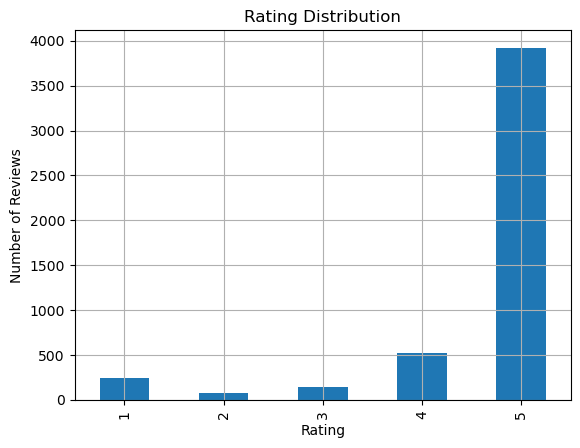

In [8]:
# Plot rating distribution
# sort_index() ensures ratings appear in order (1, 2, 3, 4, 5)
reviews_df['rating'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Rating Distribution')
plt.grid(True)
plt.show()

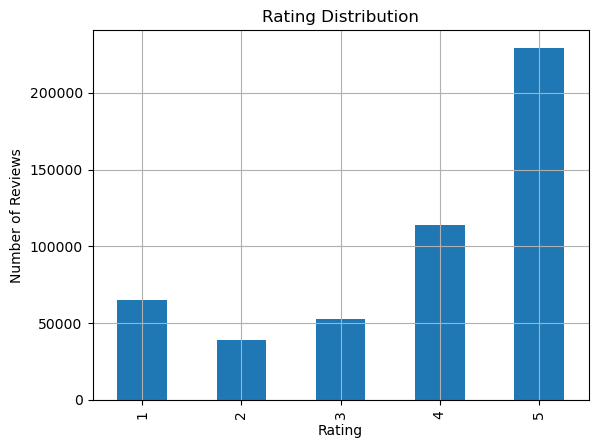

In [9]:
# sort_index() ensures ratings appear in order (1, 2, 3, 4, 5)
yelp_df['rating'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Rating Distribution')
plt.grid(True)
plt.show()

The plot diagram reveals the counts of how many reviews exist for each rating. A balanced review dataset will have evenly distributed ratings, while a skewed plot indicates imbalance. Polarization, common in product reviews, shows many 5-star and 1-star ratings but few middle ratings.

**To confirm if we have data imbalance, let's calculate the exact imbalance % in the dataset.**

In [10]:
def print_distribution(df, title):
    print(f"\n{title} Rating Distribution:")
    total_reviews = len(df)
    rating_counts = df['rating'].value_counts().sort_index()
    # Calculate % per rating
    rating_percentages = (rating_counts / total_reviews) * 100
    for rating, pct in rating_percentages.items():
        print(f"Rating {rating}: {pct:.2f}% ({rating_counts[rating]} reviews)")
    return


In [11]:

print_distribution(reviews_df, "Amazon Reviews")
print_distribution(yelp_df, "Yelp Reviews")



Amazon Reviews Rating Distribution:
Rating 1: 4.97% (244 reviews)
Rating 2: 1.63% (80 reviews)
Rating 3: 2.89% (142 reviews)
Rating 4: 10.72% (527 reviews)
Rating 5: 79.79% (3921 reviews)

Yelp Reviews Rating Distribution:
Rating 1: 13.05% (65233 reviews)
Rating 2: 7.77% (38856 reviews)
Rating 3: 10.52% (52589 reviews)
Rating 4: 22.80% (114005 reviews)
Rating 5: 45.86% (229317 reviews)


As we can see from the plot diagram and the imbalance %, that ~80% of reviews are 5 stars. Hence we can conclude that the 
data is **highly imbalanced.** And if we decide to use the data **as-is** to train the model, the model will be strongly biased
to predict 5 stars as it has so many examples.

**For LLMs and NLP models, it is very helpful to see how long the reviews are and if it needs to be truncated.**

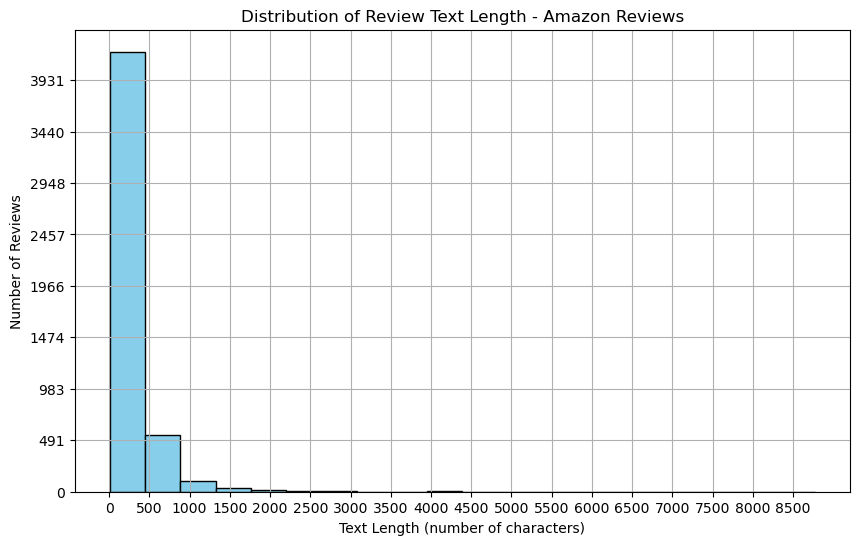

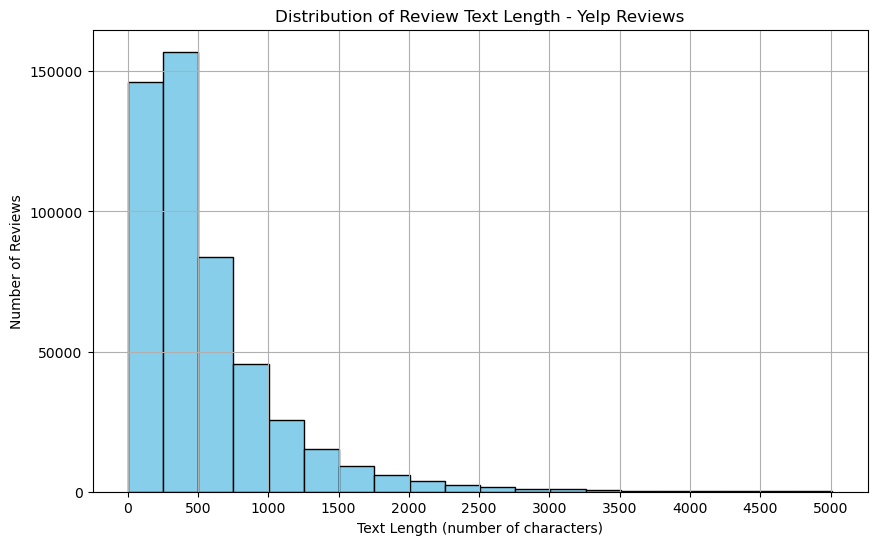

In [12]:
def plot_text_length_distribution(df, title):
    # Compute text length (in characters)
    df['text_length'] = df['review'].apply(len)
    total_reviews = len(df)

    # Plot histogram of text lengths
    plt.figure(figsize=(10,6))
    plt.hist(df['text_length'], bins=20, color='skyblue', edgecolor='black')
    plt.xlabel('Text Length (number of characters)')
    plt.ylabel('Number of Reviews')
    plt.title(f'Distribution of Review Text Length - {title}')

    # Add custom tick marks
    import numpy as np
    plt.xticks(np.arange(0, df['text_length'].max() + 1, 500))
    plt.yticks(np.arange(0, plt.ylim()[1] + 1, total_reviews/10))

    plt.grid(True)
    plt.show()

plot_text_length_distribution(reviews_df, "Amazon Reviews")
plot_text_length_distribution(yelp_df, "Yelp Reviews")


In [13]:
def print_review_length_distribution(df, title):
    # Print the percentage of reviews by length bin

    #Define bins (customize as needed)
    bins = [0, 250, 500, 1000, 2000, 10000]
    labels = ['0-250', '251-500', '501-1000', '1001-2000', '2001+']

    # Bin the review lengths
    df['length_bin'] = pd.cut(df['text_length'], bins=bins, labels=labels, right=True)

    # Calculate percentages
    bin_counts = df['length_bin'].value_counts(normalize=True).sort_index() * 100

    # Print results
    print(f"Percentage of {title} by length:")
    print(bin_counts)
    print("\nTotal reviews:", len(df), '\n')
    
print_review_length_distribution(reviews_df, "Amazon Reviews")
print_review_length_distribution(yelp_df, "Yelp Reviews")

Percentage of Amazon Reviews by length:
length_bin
0-250        64.082214
251-500      23.768824
501-1000      9.605210
1001-2000     2.035002
2001+         0.508751
Name: proportion, dtype: float64

Total reviews: 4914 

Percentage of Yelp Reviews by length:
length_bin
0-250        29.0664
251-500      31.4632
501-1000     25.9382
1001-2000    11.1854
2001+         2.3468
Name: proportion, dtype: float64

Total reviews: 500000 



The plot above shows that:

87% of the amazon reviews are under 500 characters which is very short.
There is a long tail of long reviews which are rare but present.

60% of the yelp reviews are under 500 characters. The yelp reviews provide
a better distribution of review lengths.

The distribution is highly skewed for the amazon reviews, though not as
much for the Yelp reviews.  

**BALANCE THE DATASET**

Original rating counts:
rating
1     244
2      80
3     142
4     527
5    3921
Name: count, dtype: int64

Target samples per class (smallest class): 80

Balanced rating counts:
rating
1    80
2    80
3    80
4    80
5    80
Name: count, dtype: int64


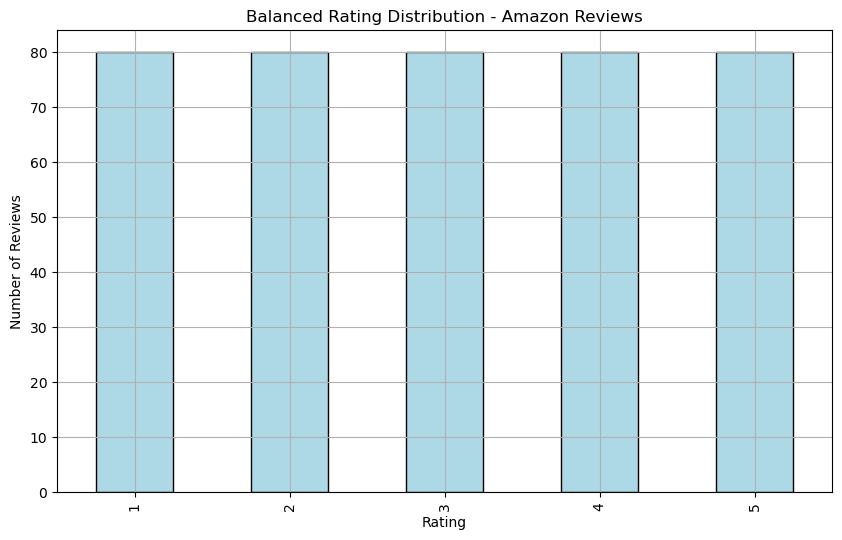

Original rating counts:
rating
1     65233
2     38856
3     52589
4    114005
5    229317
Name: count, dtype: int64

Target samples per class (smallest class): 38856

Balanced rating counts:
rating
1    38856
2    38856
3    38856
4    38856
5    38856
Name: count, dtype: int64


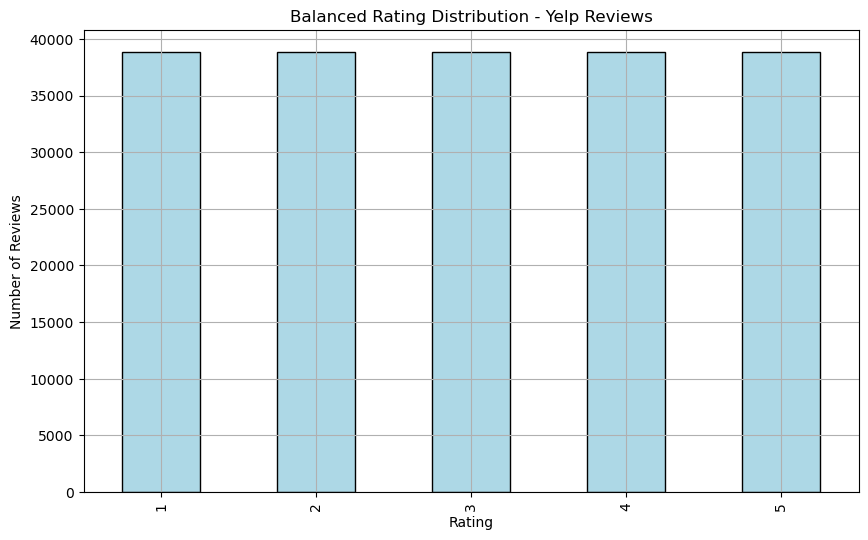

In [14]:
def graph_balanced_rating_distribution(df, title):
    # Compute current counts
    rating_counts = df['rating'].value_counts().sort_index()
    print("Original rating counts:")
    print(rating_counts)

    # Determine minimum class size
    min_count = rating_counts.min()
    print(f"\nTarget samples per class (smallest class): {min_count}")
    
    # Create a balanced dataset by ensuring each rating category has the same number of samples
    balanced_parts = []
    for rating, group in df.groupby('rating'):
        sampled = group.sample(min_count, random_state=42)
        balanced_parts.append(sampled)

    balanced_df = pd.concat(balanced_parts).reset_index(drop=True)

    # Plot the balanced rating distribution
    balanced_counts = balanced_df['rating'].value_counts().sort_index()
    print("\nBalanced rating counts:")
    print(balanced_counts)
    
    plt.figure(figsize=(10,6))
    balanced_counts.plot(kind='bar', color='lightblue', edgecolor='black')
    plt.xlabel('Rating')
    plt.ylabel('Number of Reviews')
    plt.title(f'Balanced Rating Distribution - {title}')
    plt.grid(True)
    plt.show()
    
    return balanced_df

balanced_reviews_df = graph_balanced_rating_distribution(reviews_df, "Amazon Reviews")
yelp_balance_reviews_df = graph_balanced_rating_distribution(yelp_df, "Yelp Reviews")


**MODELING PIPELINE**

In [15]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

balanced_df = yelp_balance_reviews_df

# Split the balanced data
X_train, X_test, y_train, y_test = train_test_split(
    balanced_df['review'],
    balanced_df['rating'],
    test_size=0.2,
    random_state=42
)

**Option A — TF-IDF + Ridge Regression (Baseline)**

In [16]:
# Vectorize text using TF-IDF
# Set the maximum number of features to the match the length of the review text
vectorizer = TfidfVectorizer(max_features = 2000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(vectorizer.get_feature_names_out())

['00' '10' '100' ... 'yum' 'yummy' 'zero']


In [17]:
# Train Ridge regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_tfidf, y_train)

# Predict on test set
y_pred = ridge_model.predict(X_test_tfidf)

# Evaluate model
print("TF-IDF + Ridge Regression Results")
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))

TF-IDF + Ridge Regression Results
R²: 0.6610193730775555
RMSE: 0.8236800972473778
MAE: 0.6573276149628801


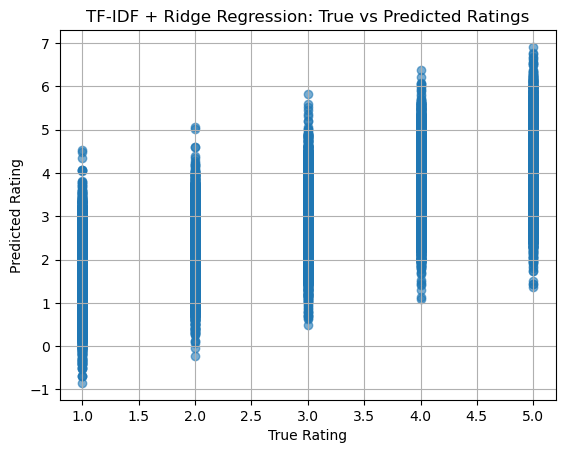

In [18]:
# Plot true vs predicted ratings
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("True Rating")
plt.ylabel("Predicted Rating")
plt.title("TF-IDF + Ridge Regression: True vs Predicted Ratings")
plt.grid(True)
plt.show()

We see a lot of spread vertically for each true rating:

Many predictions cluster around ~2 to ~4 for every true rating.The model is not confidently predicting the extreme ratings (1 or 5).

For true rating = 1, many predictions are around 2-3 instead of 1.
For true rating = 5, many predictions are around 3-4, not exactly 5.

**Overall pattern**
The model seems to have a regression to the mean behavior:

Tends to predict around 2.5 to 4 regardless of input.Less confident in predicting very low or very high ratings.

This is common in imbalanced datasets and when using Ridge regression (which penalizes large weights).

**TF-IDF WITH PROPER TEXT PREPROCESSING**

In [19]:
# Install NLTK if needed
#!pip install nltk

# Import libraries
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources (first time only)
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define preprocessing function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = text.split()
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Join back to string
    return ' '.join(tokens)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jim.mccarthy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jim.mccarthy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
# Apply preprocessing to train and test text
X_train_processed = X_train.apply(preprocess_text)
X_test_processed = X_test.apply(preprocess_text)

In [21]:
# Vectorize preprocessed text
vectorizer = TfidfVectorizer(max_features=500)
X_train_tfidf = vectorizer.fit_transform(X_train_processed)
X_test_tfidf = vectorizer.transform(X_test_processed)

# Train Ridge regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_tfidf, y_train)

# Predict on test set
y_pred_preprocessed = ridge_model.predict(X_test_tfidf)

# Evaluate model
print("TF-IDF + Ridge (with preprocessing) Results")
print("R²:", r2_score(y_test, y_pred_preprocessed))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_preprocessed)))
print("MAE:", mean_absolute_error(y_test, y_pred_preprocessed))

TF-IDF + Ridge (with preprocessing) Results
R²: 0.5648301841455532
RMSE: 0.9332554075616871
MAE: 0.7474018856100095


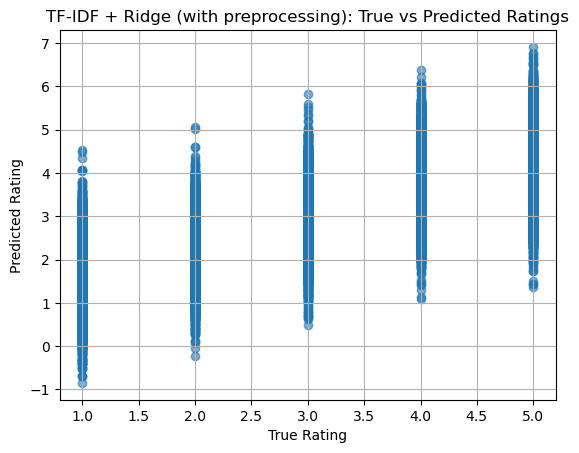

In [22]:
# Plot true vs predicted ratings
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("True Rating")
plt.ylabel("Predicted Rating")
plt.title("TF-IDF + Ridge (with preprocessing): True vs Predicted Ratings")
plt.grid(True)
plt.show()


**Sentence-BERT + RandomForestRegressor (Better semantics)**

In [23]:
#import sys
#!{sys.executable} -m pip install sentence-transformers

In [24]:
# Install SentenceTransformers if not already installed
#%pip install sentence-transformers

# Import necessary libraries
from sentence_transformers import SentenceTransformer 
from sklearn.ensemble import RandomForestRegressor

# Load Sentence-BERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight, fast model

# Encode training and test sentences
X_train_embeddings = sbert_model.encode(X_train.tolist(), show_progress_bar=True)
X_test_embeddings = sbert_model.encode(X_test.tolist(), show_progress_bar=True)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_embeddings, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test_embeddings)

# Evaluate model
print("Sentence-BERT + RandomForestRegressor Results")
print("R²:", r2_score(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))

AttributeError: module 'x509' has no attribute 'VerifiedClient'

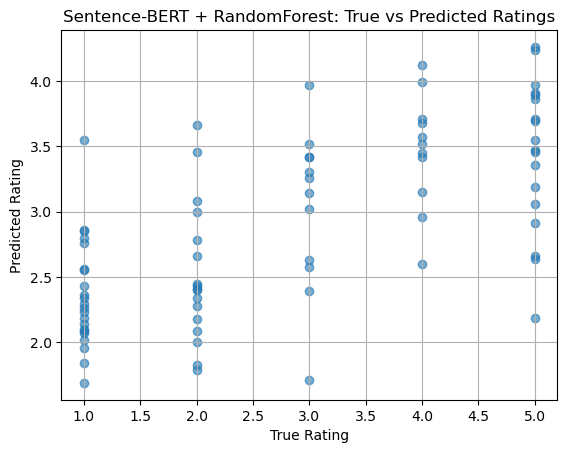

In [ ]:
# Plot true vs predicted ratings
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.xlabel("True Rating")
plt.ylabel("Predicted Rating")
plt.title("Sentence-BERT + RandomForest: True vs Predicted Ratings")
plt.grid(True)
plt.show()

Observations:

For higher true ratings (4, 5), the predicted ratings tend to be higher.
For lower true ratings (1, 2), the predictions are lower.
For true rating 1:
Predicted ratings mostly between ~1.7 to ~3.5.
The model struggles to predict exactly 1.
For true rating 5:
Predicted ratings mostly between ~2.9 to ~4.3.
The model under-predicts the highest ratings.
The model shows regression to the mean behavior:
Many predictions cluster around ~2.5 to ~3.5, even for extreme true ratings.

In [ ]:
# Calculate metrics
# Sentence-BERT + RandomForestRegressor
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

# TF-IDF + Ridge Regression
r2_ridge = r2_score(y_test, y_pred)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred))
mae_ridge = mean_absolute_error(y_test, y_pred)


# TF-IDF + Ridge (with preprocessing) Results
r2_ridge_preprocessing = r2_score(y_test, y_pred)
rmse_ridge_preprocessing = np.sqrt(mean_squared_error(y_test, y_pred))
mae_ridge_preprocessing = mean_absolute_error(y_test, y_pred)

# Create DataFrame
results_df = pd.DataFrame({
    'Model': ['Sentence-BERT + RandomForestRegressor', 'TF-IDF + Ridge Regression', 'TF-IDF + Ridge Regression(preprocessing)'],
    'R2': [r2_rf, r2_ridge, r2_ridge_preprocessing],
    'RMSE': [rmse_rf, rmse_ridge, rmse_ridge_preprocessing],
    'MAE': [mae_rf, mae_ridge, mae_ridge_preprocessing]
})

# Display DataFrame
print(results_df)

                                      Model        R2      RMSE       MAE
0     Sentence-BERT + RandomForestRegressor  0.397541  1.182087  0.991625
1                 TF-IDF + Ridge Regression  0.385398  1.193940  1.011651
2  TF-IDF + Ridge Regression(preprocessing)  0.385398  1.193940  1.011651


In [ ]:
#!pip install transformers datasets


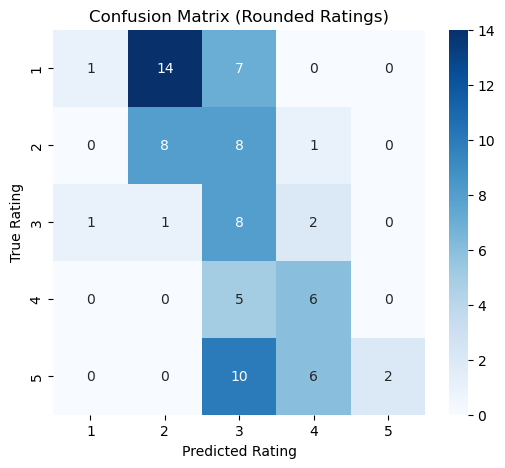

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Round predictions to nearest integer between 1 and 5
y_pred_rounded = np.clip(np.round(y_pred), 1, 5)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rounded, labels=[1, 2, 3, 4, 5])

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1,2,3,4,5],
            yticklabels=[1,2,3,4,5])
plt.xlabel("Predicted Rating")
plt.ylabel("True Rating")
plt.title("Confusion Matrix (Rounded Ratings)")
plt.show()

**Ratings 1 and 2:**
True rating 1 → 14 predicted as 2, 7 as 3 → model struggles to predict 1-star correctly. Only 1 correctly predicted as 1.

The model tends to underestimate how bad the review is.

True rating 2 → 8 predicted as 2 → this is decent.

But 8 predicted as 3 → confused between 2 and 3.

👉 Conclusion → Model struggles to predict very low ratings (1, 2). Tends to shift them toward the middle (3).

**Ratings 3:**
True rating 3 → 8 predicted correctly.

2 predicted as 4 → some tendency to slightly overpredict.

👉 Conclusion → Model is reasonably accurate at predicting 3-star reviews.

**Ratings 4:**
True rating 4 → 6 correctly predicted as 4.

5 predicted as 3 → tendency to underpredict 4-star reviews a bit.

**Ratings 5:**
True rating 5 → only 2 predicted correctly.

10 predicted as 3, 6 as 4 → model strongly underpredicts 5-star reviews.

👉 Conclusion → Model struggles with 5-star reviews — tends to push them toward 3 or 4.